# Identification of design margins in the design of a strut

## Defining the components of the margin analysis network

The components of the margin analysis network are:

* Input parameters
    * Design parameters
    * Fixed parameters
    * Input specifications
* Intermediate parameters
* Output parameters
    * Performance parameters
    * Target thresholds
    * Decided values

### Design parameters

<p style="text-align:center;">
    <img src="../images/strut_example/strut_overview.png" alt="strut location" title="location of strut in the turbine rear frame" width="650px" align="center"/>
</p>

This example shows how to evaluate the design margins of a strut which is a part of the turbine rear frame of an aeroengine. In this example, we consider three design parameters of the strut the lean angle $\theta$, the vane width $w$, and the vane height $h$

In [43]:
from dmLib import DesignParam

# define design parameters
d1 = DesignParam(100.0  ,'D1'   ,universe=(70.0,130.0)  ,description='vane length'  ,symbol='w'     )
d2 = DesignParam(15.0   ,'D2'   ,universe=(5.0,20.0)    ,description='vane height'  ,symbol='h'     )
d3 = DesignParam(10.0   ,'D3'   ,universe=(0.0,30.0)    ,description='lean angle'   ,symbol='theta' )
design_params = [d1,d2,d3]

### Fixed parameters

We also specify some constants for this example, such as elastic modulus $E$, coefficient of thermal expansion $\alpha$, hub and shroud radii, $r_1$ and $r_2$, respectively.

In [44]:
from dmLib import FixedParam

# define fixed parameters
i1 = FixedParam(7.17E-06    ,'I1',description='Coefficient of thermal expansion'    ,symbol='alpha'     )
i2 = FixedParam(156.3E3     ,'I2',description='Youngs modulus'                      ,symbol='E'         )
i3 = FixedParam(8.19e-06    ,'I3',description='Material density'                    ,symbol='rho'       )
i4 = FixedParam(346.5       ,'I4',description='Radius of the hub'                   ,symbol='r1'        )
i5 = FixedParam(536.5       ,'I5',description='Radius of the shroud'                ,symbol='r2'        )
i6 = FixedParam(1.0         ,'I6',description='Column effective length factor'      ,symbol='K'         )
i7 = FixedParam(25.0        ,'I7',description='ambient temperature'                 ,symbol='Ts'        )
i8 = FixedParam(460.0       ,'I8',description='yield stress'                        ,symbol='sigma_y'   )
fixed_params = [i1,i2,i3,i4,i5,i6,i7,i8]

### Input specifications

The strut experiences a compressive force $F$ and bending moment $M$ as a result of non-uniform expansion of the turbine rear frame during operation.

<p style="text-align:center;">
    <img src="../images/strut_example/simplified_strut_model.png" alt="strut location" title="location of strut in the turbine rear frame" width="650px" align="center"/>
</p>

Furthermore, the yield stress of the material $\sigma_y$ is another specification that has a fixed value of 460 MPa. The argument ``inc`` specifies the expected direction of change during operation and will be used later on to compute the ability of a design margin to absorb change

* $T_1$ is expected to decrease
* $T_2$ is expected to increase

In [45]:
from dmLib import InputSpec

# define input specifications
s1 = InputSpec(450,'S1',universe=(325,550),description='nacelle temperature',
    symbol='T1',inc = -1e-2,inc_type='rel')
s2 = InputSpec(425,'S2',universe=(325,550),description='gas surface temperature',
    symbol='T2',inc=+1e-2,inc_type='rel')
input_specs = [s1,s2,]

### Intermediate parameters

We calculate the *intermediate parameter* $L$ which gives the length of the strut as

$$
L = -r_1\cos{\theta} + \sqrt{{r_2}^2 - {r_1}^2\sin^2{\theta}}
$$

This is given by a *behaviour* model ``b1``

In [46]:
from dmLib import Behaviour
import numpy as np

# this is the length model
class B1(Behaviour):
    def __call__(self,theta,r1,r2):
        length=-r1*np.cos(np.deg2rad(theta)) + np.sqrt(r2**2 - (r1*np.sin(np.deg2rad(theta)))**2)
        self.intermediate = length

b1 = B1('B1')

### Performance parameters

we then calculate weight as:

$$
W = \rho whL
$$

This is a *performance parameter*

In [47]:
# this is the weight model
class B2(Behaviour):
    def __call__(self,rho,w,h,L):
        weight = rho*w*h*L
        self.performance = weight

b2 = B2('B2')

We specify whether increasing this parameter is beneficial or detrimental to the design's perforsto_sto_sto_mance using the ``type`` argument

In [48]:
from dmLib import Performance
# Define performances
p1 = Performance('P1',type='less_is_better')
performances = [p1,]

### Target thresholds

The strut must support:

* A compressive force $F$
* A compressive stress $\sigma_a$ due to the force $F$
* A bending stress $\sigma_m$ due to the bending moment $M$

$$
F = \dfrac{Ewh\alpha}{L}\left(T_2r_2 - T_1r_1 - T_\text{sink}(r_2-r_1)\right)\cos{\theta}\\
\sigma_a = \dfrac{E\alpha}{L}\left(T_2r_2 - T_1r_1 - T_\text{sink}(r_2-r_1)\right)\cos{\theta}\\
\sigma_m =\dfrac{3}{2}\dfrac{Eh\alpha}{L^2}\left(T_2r_2 - T_1r_1 - T_\text{sink}(r_2-r_1)\right)\sin{\theta}
$$

They are given by *behaviour* models ``b3`` and ``b4``

In [49]:
# this is the axial stress model
class B3(Behaviour):
    def __call__(self,alpha,E,r1,r2,Ts,T1,T2,w,h,theta,L):
        force = (E*w*h*alpha)*((T2*0.95*r2)-(T1*r1)-(Ts*(r2-r1)))*np.cos(np.deg2rad(theta)) / L
        sigma_a = (E*alpha)*((T2*1.05*r2)-(T1*r1)-(Ts*(r2-r1)))*np.cos(np.deg2rad(theta)) / L
        self.threshold = [force/1000,sigma_a]

# this is the bending stress model
class B4(Behaviour):
    def __call__(self,alpha,E,r1,r2,Ts,T1,T2,h,theta,L):
        sigma_m = (3/2)*((E*h)/(L**2))*(alpha*((T2*0.97*r2)-(T1*r1)-(Ts*(r2-r1)))*np.sin(np.deg2rad(theta)))
        self.threshold = sigma_m

b3 = B3('B3')
b4 = B4('B4')

### Decided values (the load carrying capacity of the design)

The design can support the following loads

* A buckling load $F_\text{buckling} = \dfrac{\pi^2Ewh^3}{12\left(KL\right)^2}$
* A maximum axial stress equal to the yield stress $\sigma_y$
* A maximum bending stress equal to the yield stress $\sigma_y$

we only define a model for the buckling load $F_\text{buckling}$ since the maximum axial and bending stresses are equal to input specification ``s3`` for the yield stress.

In [50]:
# this is the buckling model
class B5(Behaviour):
    def __call__(self,E,K,w,h,L):
        f_buckling = ((np.pi**2)*E*w*(h**3)) / (12*((K*L)**2))
        self.decided_value = f_buckling/1000

b5 = B5('B4')

We concatenate all behaviour models into a list

In [51]:
behaviours = [b1,b2,b3,b4,b5]

### Design margins

We have three design margins given by:

$$
e_1 = F_\text{buckling} - F\\
e_2 = \sigma_y - \sigma_a\\
e_3 = \sigma_y - \sigma_m
$$

They are all of the ``must_not_exceed`` type

In [52]:
from dmLib import MarginNode

# Define margin nodes
e1 = MarginNode('E1',type='must_not_exceed')
e2 = MarginNode('E2',type='must_not_exceed')
e3 = MarginNode('E3',type='must_not_exceed')
margin_nodes = [e1,e2,e3]

### Calculation of the value of excess margins in the strut

#### Constructing the margin analysis network

We combine all the perviously defined parameters and behaviour models inside a ``MarginNetwork`` object. The ``forward`` method represents a single calculation pass of the margin analysis network

The ``randomize`` method is optional and is used to randomly seed any probabilistic input specifications or behaviour models.

In [53]:
from dmLib import MarginNetwork

# Define the MAN
class MAN(MarginNetwork):

    def forward(self):

        # retrieve MAN components
        d1 = self.design_params[0] # w
        d2 = self.design_params[1] # h
        d3 = self.design_params[2] # theta

        s1 = self.input_specs[0] # T1 (stochastic)
        s2 = self.input_specs[1] # T2 (stochastic)

        i1 = self.fixed_params[0] # alpha
        i2 = self.fixed_params[1] # E
        i3 = self.fixed_params[2] # rho
        i4 = self.fixed_params[3] # r1
        i5 = self.fixed_params[4] # r2
        i6 = self.fixed_params[5] # K
        i7 = self.fixed_params[6] # Ts
        i8 = self.fixed_params[7] # sigma_y 

        b1 = self.behaviours[0] # calculates length
        b2 = self.behaviours[1] # calculates weight
        b3 = self.behaviours[2] # calculates axial force and stress
        b4 = self.behaviours[3] # calculates bending stress
        b5 = self.behaviours[4] # calculates buckling load

        e1 = self.margin_nodes[0] # margin against buckling (F,F_buckling)
        e2 = self.margin_nodes[1] # margin against axial failure (sigma_a,sigma_y)
        e3 = self.margin_nodes[2] # margin against bending failure (sigma_m,sigma_y)

        p1 = self.performances[0] # weight

        # Execute behaviour models
        b1(d3.value,i4.value,i5.value)
        b2(i3.value,d1.value,d2.value,b1.intermediate)
        b3(i1.value,i2.value,i4.value,i5.value,i7.value,s1.value,s2.value,d1.value,d2.value,d3.value,b1.intermediate)
        b4(i1.value,i2.value,i4.value,i5.value,i7.value,s1.value,s2.value,d2.value,d3.value,b1.intermediate)
        b5(i2.value,i6.value,d1.value,d2.value,b1.intermediate)

        # Compute excesses
        e1(b3.threshold[0],b5.decided_value)
        e2(b3.threshold[1],i8.value)
        e3(b4.threshold,i8.value)

        # Compute performances
        p1(b2.performance)

man = MAN(design_params,input_specs,fixed_params,
    behaviours,margin_nodes,performances,'MAN_1')

### Calculating the impact of excess margin on performance

To calculate the level of overdesign w.r.t margin node $m$ and performance parameter $j$ given by

$$
\text{impact}_{mj} = \dfrac{p_j - p^\text{threshold}_{mj}}{p^\text{threshold}_{mj}}
$$

we need to calculate the threshold performance $p^\text{threshold}_{mj}$, i.e., the weight of a hypothetical design where margin node $e_m = 0$, To do so, we construct a surrogate model for the performance parameters $\mathbf{p}$ in terms of the excess values $\mathbf{e}$ and input specifications $\mathbf{s}$

$$
\hat{\mathbf{p}} = f(\mathbf{e},\mathbf{s})
$$

we substitute $e_m = 0$ while holding all the other components at their nominal values.

In [54]:
# Create surrogate model for estimating threshold performance
man.train_performance_surrogate(n_samples=700,bandwidth=[1e-1,])

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 700
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 10.5631788


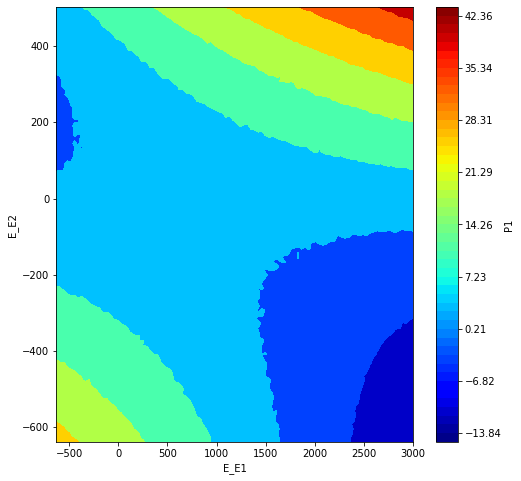

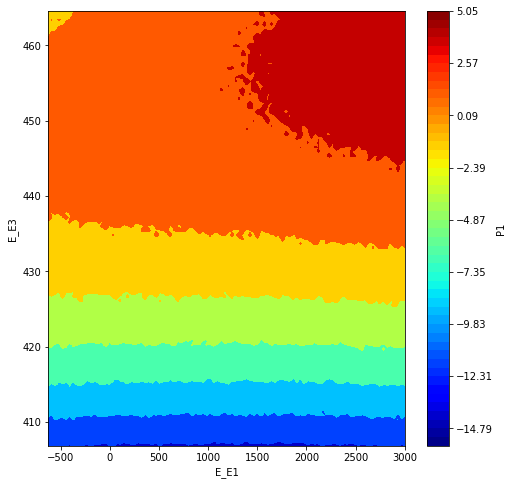

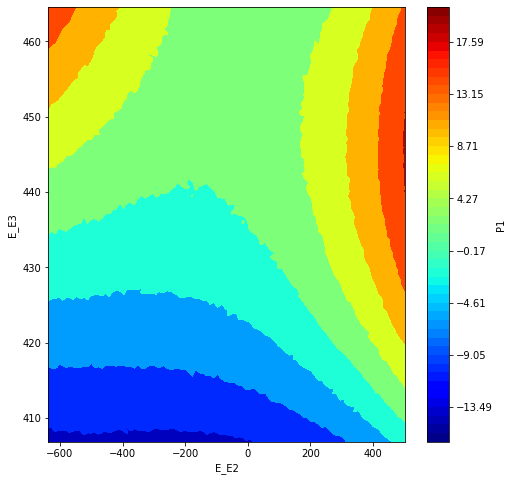

In [55]:
man.reset()
man.forward()
man.view_perf(e_indices=[0,1],p_index=0)
man.view_perf(e_indices=[0,2],p_index=0)
man.view_perf(e_indices=[1,2],p_index=0)

We now calculate the impact using ``dmLib`` using the Kriging surrogate model

$$
\text{impact}_{mj} = \dfrac{p_j - \hat{p}^\text{threshold}_{mj}}{\hat{p}^\text{threshold}_{mj}}
$$

In [56]:
man.compute_impact()
man.impact_matrix.impact

array([[ 0.32003083],
       [-0.00850532],
       [-1.0005336 ]])

* The first margin node (against buckling) has a positive impact on performance. This means that the excess in this node is causing additional overdesign due to added weight
* The third margin node (against to bending) has a negative impact. This means that increasing this margin will also reduce the weight of the design. This is expected because for a given displacement load $\delta$ it is easier to bend a beam with a thinner cross-section compared to thicker beam

### Calculation of change absorption capability

We now calculate the ability of the design to absorb deviation in the input specifications from their nominal values. We incrementally increase or decrease each specification $s_i$ until one of the margin nodes is equal to 0. The value of the specification at this point is called $s^\text{max}_i$. The maximum allowable deterioration in the input specification is give by

$$
\text{deterioration}_i = \dfrac{s^\text{max}_i - s_i}{s_i}
$$

In [57]:
man.compute_absorption()
man.spec_vector - man.absorption_matrix.deterioration * man.spec_vector

array([446.4 , 422.79])

The value of the target thresholds when $s^\text{max}_i$ is reached is $\mathbf{t}^\text{new}$. The value of the target thresholds at the nominal specifications $s_i$ is $\mathbf{t}^\text{nominal}$. The change absorption per unit deterioration is given by

$$
\text{absorption}_{mi} = \dfrac{t^\text{new}_{mi} - t^\text{nominal}_{mi}}{t^\text{nominal}_{mi}\times\text{deterioration}_i}
$$

In [58]:
man.absorption_matrix.absorption

array([[2.78751718, 3.87243433],
       [1.98029862, 3.04062517],
       [2.57739521, 3.65591133]])

### Tradeoff between impact and absorption

We average the absorption and impact across all input specifications and performance parameters for each margin node (assuming equal weighting)

$$
{a}_m = \dfrac{1}{n_\text{specs}}\sum_{i=0}^{n_\text{specs}} \text{absorption}_{mi} \\
{i}_m = \dfrac{1}{n_\text{perf}}\sum_{j=0}^{n_\text{perf}} \text{impact}_{mj} \\
$$

and scatter plot the components of $\mathbf{a}$ and $\mathbf{i}$ on a tradespace to produce the margin value plot

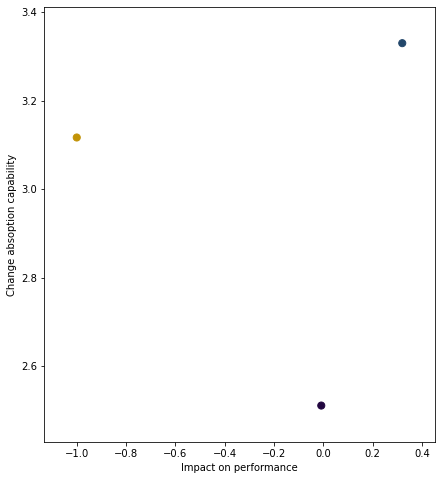

0.5150701990701222

In [59]:
man.compute_MVP('scatter')

### The effect of design parameters on change absorption and impact on performance

Let us look at an alternative design given by different values of $w$, $h$, and $\theta$

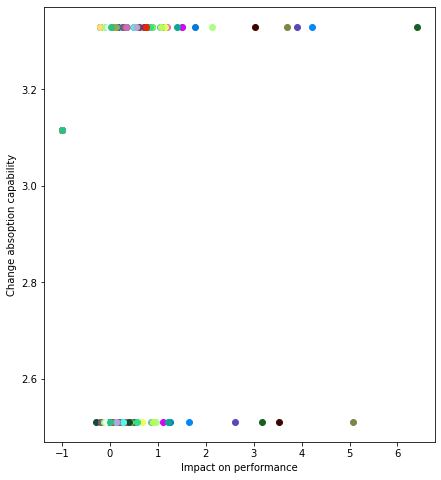

In [65]:
from dmLib import Design
import matplotlib.pyplot as plt

# Effect of alternative designs
n_designs=100
n_epochs = 10
design_doe = Design(man.lb_d,man.ub_d,n_designs,'LHS')

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')

X = np.empty((1,len(man.margin_nodes)))
Y = np.empty((1,len(man.margin_nodes)))
D = np.empty((1,len(man.design_params)))

for i,design in enumerate(design_doe.unscale()):
    man.nominal_design_vector = design
    man.reset()
    man.reset_outputs()

    # Display progress bar
    sys.stdout.write("Progress: %d%%   \r" %((i/n_designs)* 100))
    sys.stdout.flush()

    # Perform MAN computations
    man.forward()
    man.compute_impact()
    man.compute_absorption()
    
    # Extract x and y
    x = np.mean(man.impact_matrix.impacts,axis=(1,2)).ravel() # average along performance parameters (assumes equal weighting)
    y = np.mean(man.absorption_matrix.absorptions,axis=(1,2)).ravel() # average along input specs (assumes equal weighting)

    if not all(np.isnan(y)):
        X = np.vstack((X,x))
        Y = np.vstack((Y,y))
        D = np.vstack((D,design))

    # plot the results
    color = np.random.random((1,3))
    ax.scatter(x,y,c=color)

plt.show()

The scatter plot shows the relative position of different designs on the margin value plot. We can calculate the distance metric $d$ as a way to evaluate alternatives. We show an example for the first three designs we explored

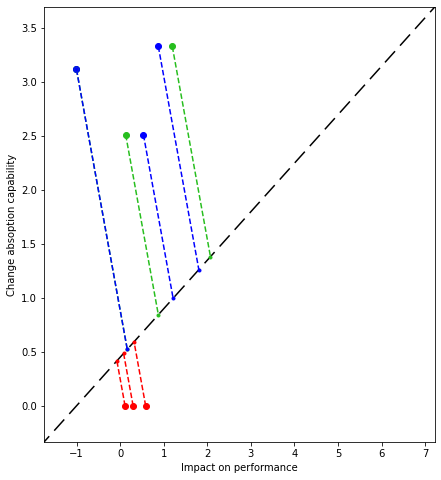

In [66]:
# Calculate the maximum and minimum observed absorption and impact
p1 = np.array([X.min(),Y.min()])
p2 = np.array([X.max(),Y.max()])
p1 = p1 - 0.1*abs(p2 - p1)
p2 = p2 + 0.1*abs(p2 - p1)

# display distances only for three designs
X_plot = X[0:3,:]
Y_plot = Y[0:3,:]

# create empty figure
colors = ['#FF0000','#27BE1E','#0000FF']
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')
ax.set_xlim(p1[0],p2[0])
ax.set_ylim(p1[1],p2[1])

p = ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k',linestyle=(5,(10,5)))

for i,(x,y) in enumerate(zip(X_plot,Y_plot)):

    ax.scatter(x,y,c=colors[i])

    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)

        x_d = [s[0],pn[0]]
        y_d = [s[1],pn[1]]
        ax.plot(x_d,y_d,marker='.',linestyle='--',color=colors[i])

plt.show()

We can calculate the same metric for all the design we explored earlier 

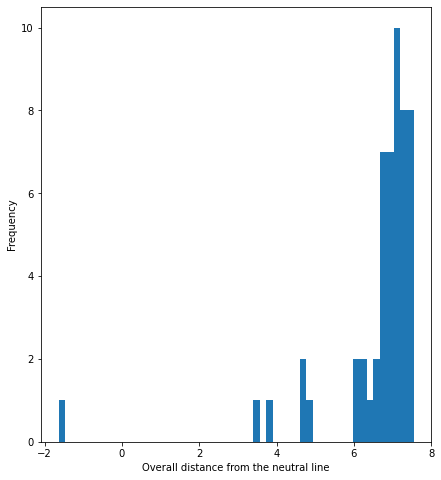

---------------------------------
The best design:
w = 78.572
h = 11.083
theta = 18.571
---------------------------------


In [73]:

distances = np.empty(0)
for i,(x,y) in enumerate(zip(X,Y)):

    dist = 0
    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)
        dist += d

    distances = np.append(distances,dist)

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Overall distance from the neutral line')
ax.set_ylabel('Frequency')
ax.hist(distances,bins=len(distances))

plt.show()

best_i = np.argmax(distances)
best_design = D[best_i,:]

print('---------------------------------')
result = 'The best design:\n'
for value,d_object in zip(best_design,man.design_params):
    result += d_object.symbol + ' = ' + '%.3f'%value + '\n'

result += '---------------------------------'
print(result)

## Effect of uncertainty in the nominal values of the input specifications $T_1$ and $T_2$

This caused by unequal temperatures $T_1$, and $T_2$. Their exact values are not known and are expected to vary. We model this uncertainty using a joint probability density function:

$$
T_1,T_2 \sim \mathcal{N}(\boldsymbol{\mu},\boldsymbol{\Sigma})
$$

where $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ are the means and covariances, respectively of multivariate normal distribution

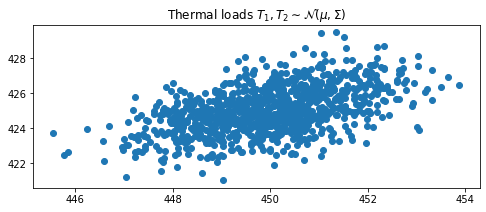

In [74]:
from dmLib import gaussianFunc, uniformFunc
import numpy as np

# T1,T2 distribution (Gaussian)
center = np.array([450,425])
Sigma = np.array([
    [100, 25],
    [75, 100],
    ]) / (20*3)
Requirement = gaussianFunc(center, Sigma, 'temp')

# # T1,T2 distribution (Uniform)
# center = np.array([450,425])
# Range = np.array([100, 100])/20
# Requirement = uniformFunc(center, Range, 'temp')

Requirement(1000)
Requirement.view(xlabel='Thermal loads $T_1,T_2 \
    \sim \mathcal{N}(\mu,\Sigma)$')
Requirement.reset()

We define the random input specifications as follows by supplying the arguments ``cov_index`` and ``distribution``

In [75]:
from dmLib import InputSpec

# define input specifications
s1 = InputSpec(center[0],'S1',universe=(325,550),cov_index=0,description='nacelle temperature',
    distribution=Requirement,symbol='T1',inc = -1e-0,inc_type='rel')
s2 = InputSpec(center[1],'S2',universe=(325,550),cov_index=1,description='gas surface temperature'
    ,distribution=Requirement,symbol='T2', inc = +1e-0,inc_type='rel')
input_specs = [s1,s2,]

We define the ``randomize`` method to allow the MAN to draw random samples on input specs $T_1$ and $T_2$

In [76]:
# Define the stochastic MAN
class StoMAN(MAN):

    def randomize(self):
        Requirement()
        s1()
        s2()

sto_man = StoMAN(design_params,input_specs,fixed_params,
    behaviours,margin_nodes,performances,'MAN_2')

# Create surrogate model for estimating threshold performance
sto_man.train_performance_surrogate(n_samples=700,bandwidth=[1e-1,])

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 700
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 11.3590777



We use a Monte-Carlo simulation to obtain the distribution of impact and absorption in the design

In [77]:
import sys

# Perform Monte-Carlo simulation
n_epochs = 10000
for n in range(n_epochs):
    
    sys.stdout.write("Progress: %d%%   \r" %((n/n_epochs)* 100)) # display progress
    sys.stdout.flush()

    sto_man.randomize()
    sto_man.forward()
    sto_man.compute_impact()
    sto_man.compute_absorption()

We view the distribution of excess

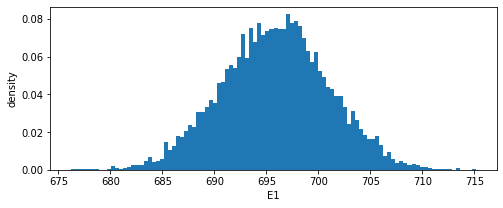

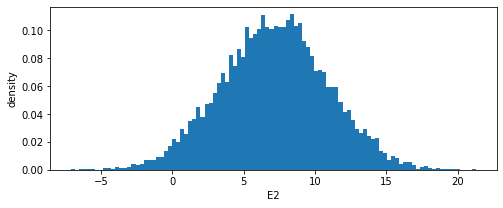

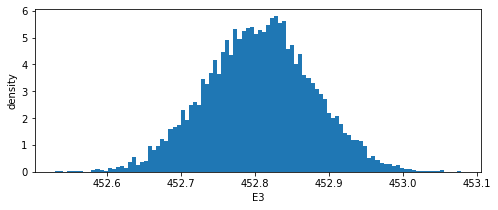

In [22]:
# View distribution of excess
sto_man.margin_nodes[0].view()
sto_man.margin_nodes[1].view()
sto_man.margin_nodes[2].view()

we view the distribution of impact on performance

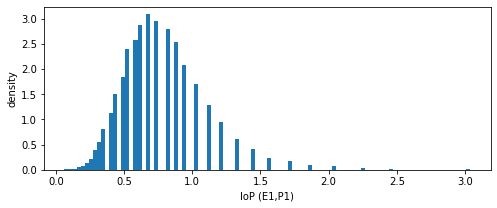

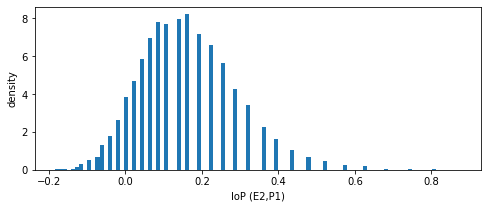

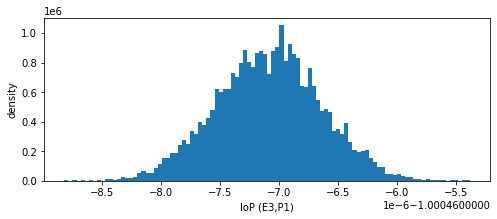

In [23]:
# View distribution of Impact on Performance
sto_man.impact_matrix.view(0,0)
sto_man.impact_matrix.view(1,0)
sto_man.impact_matrix.view(2,0)

We view the distribution of change absorption capability of margin node 1

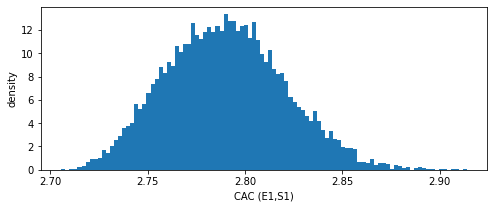

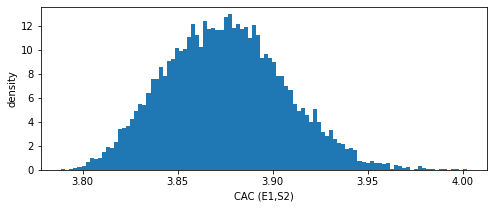

In [24]:
sto_man.absorption_matrix.view(0,0)
sto_man.absorption_matrix.view(0,1)

Finally, we view the margin value plot

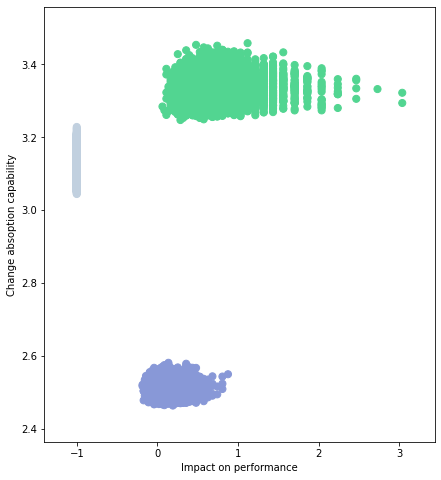

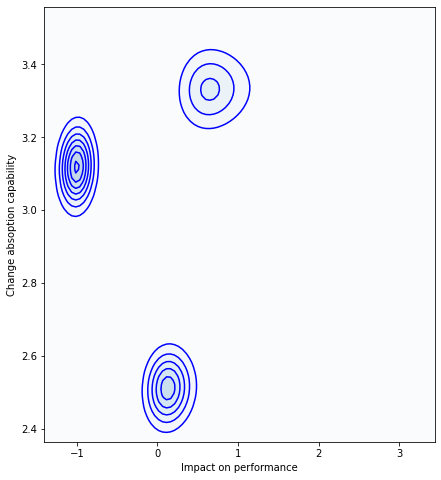

0.6359578277310683

In [25]:
# display the margin value plot
sto_man.compute_MVP('scatter')
sto_man.compute_MVP('density')

### The effect of design parameters on change absorption and impact on performance

Let us look at an alternative design given by different values of $w$, $h$, and $\theta$

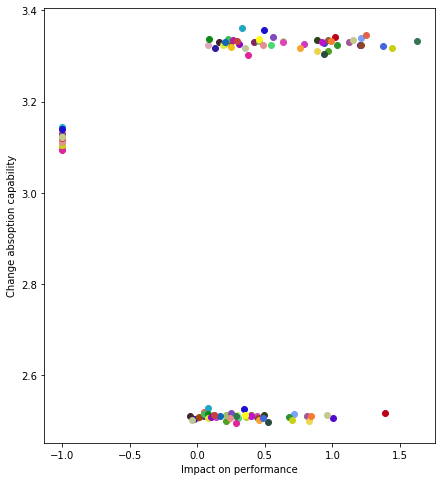

In [34]:
from dmLib import Design
import matplotlib.pyplot as plt

# Effect of alternative designs
n_designs=100
n_epochs = 10
design_doe = Design(sto_man.lb_d,sto_man.ub_d,n_designs,'LHS')

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')

X = np.empty((1,len(man.margin_nodes)))
Y = np.empty((1,len(man.margin_nodes)))
D = np.empty((1,len(man.design_params)))

for d,design in enumerate(design_doe.unscale()):
    sto_man.nominal_design_vector = design
    sto_man.reset()
    sto_man.reset_outputs()

    # Perform Monte-Carlo simulation
    for n in range(n_epochs):
        
        sys.stdout.write("Progress: %d%%   \r" %(((d*n_epochs + n)/(n_designs*n_epochs)* 100)))       
        sys.stdout.flush()

        sto_man.randomize()
        sto_man.forward()
        sto_man.compute_impact()
        sto_man.compute_absorption()
    
    # Extract x and y
    x = np.mean(sto_man.impact_matrix.impacts,axis=(1,2)).ravel() # average along performance parameters (assumes equal weighting)
    y = np.mean(sto_man.absorption_matrix.absorptions,axis=(1,2)).ravel() # average along input specs (assumes equal weighting)

    if not all(np.isnan(y)):
        X = np.vstack((X,x))
        Y = np.vstack((Y,y))
        D = np.vstack((D,design))

    # plot the results
    color = np.random.random((1,3))
    ax.scatter(x,y,c=color)

plt.show()

Now we calculate the distance to the neutral line to rank different designs

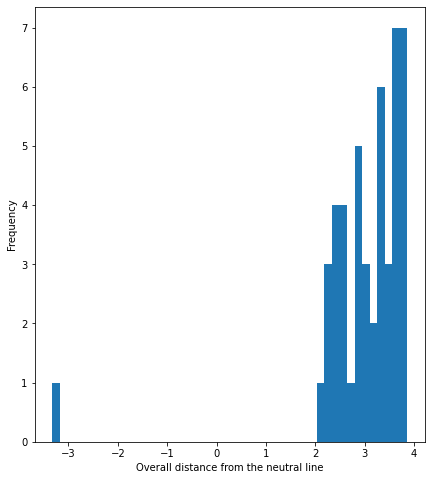

---------------------------------
The best design:
w = 406.966
h = 410.285
theta = 13.116
---------------------------------


In [42]:
from dmLib import nearest

# Calculate distance metric
p1 = np.array([X.min(),Y.min()])
p2 = np.array([X.max(),Y.max()])
p1 = p1 - 0.1*abs(p2 - p1)
p2 = p2 + 0.1*abs(p2 - p1)

distances = np.empty(0)
for i,(x,y) in enumerate(zip(X,Y)):

    dist = 0
    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)
        dist += d

    distances = np.append(distances,dist)

# create empty figure
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Overall distance from the neutral line')
ax.set_ylabel('Frequency')
ax.hist(distances,bins=len(distances))

plt.show()

best_i = np.argmax(distances)
best_design = D[best_i,:]

print('---------------------------------')
result = 'The best design:\n'
for value,d_object in zip(best_design,sto_man.design_params):
    result += d_object.symbol + ' = ' + '%.3f'%value + '\n'

result += '---------------------------------'
print(result)


Let us visualize the distance calculation for three different designs

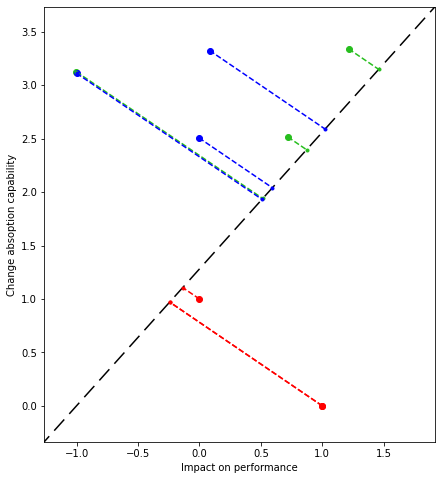

In [40]:

# display distances only for three designs
X_plot = X[0:3,:]
Y_plot = Y[0:3,:]

# create empty figure
colors = ['#FF0000','#27BE1E','#0000FF']
fig, ax = plt.subplots(figsize=(7, 8))
ax.set_xlabel('Impact on performance')
ax.set_ylabel('Change absoption capability')
ax.set_xlim(p1[0],p2[0])
ax.set_ylim(p1[1],p2[1])

p = ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='k',linestyle=(5,(10,5)))

distances = np.empty(0)
for i,(x,y) in enumerate(zip(X_plot,Y_plot)):

    ax.scatter(x,y,c=colors[i])

    dist = 0
    for node in range(len(x)):
        s = np.array([x[node],y[node]])
        pn,d = nearest(p1,p2,s)
        dist += d

        x_d = [s[0],pn[0]]
        y_d = [s[1],pn[1]]
        ax.plot(x_d,y_d,marker='.',linestyle='--',color=colors[i])

    distances = np.append(distances,dist)

plt.show()